# Graph Neural Network

## Importing

In [1]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading aid_list

In [2]:
aid_list = pd.read_csv("results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

In [3]:
aid_list

array([    884,     891,     899,     914,    1418,    1431,    1770,
          1771,    1795,  493073,  493102,  493177,  493191,  493240,
        588834,  651741,  651812,  651814,  686978,  687022,  720691,
        743036,  743040,  743065, 1053173, 1259381, 1346982])

In [4]:
# for one aid now
aid = aid_list[0]
random_state = 131313

## Select mode: smooth for 2 dim label and hard for 1-dim label

In [5]:
# mode = "smooth"
mode = "hard"

## Load pytorch data

In [6]:
whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True)

In [7]:
whole_data[:4]

[Data(x=[19, 9], edge_index=[2, 42], edge_attr=[42, 3], smiles='CC1(C=CC2=C(O1)C3=C(C=CC(=C3)OC)NC2=O)C', y=[1]),
 Data(x=[10, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='C1CN=C(N1)SCC(=O)O', y=[1]),
 Data(x=[29, 9], edge_index=[2, 64], edge_attr=[64, 3], smiles='CC(=O)OCC(=O)[C@]1(CC[C@@H]2[C@@]1(CC(=O)[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C)O', y=[1]),
 Data(x=[25, 9], edge_index=[2, 56], edge_attr=[56, 3], smiles='C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CC[C@@]4(C(=O)CO)O)C', y=[1])]

In [8]:
# build labels for split
labels_hard = np.array([
    data.y.detach().cpu().numpy()
    for data in whole_data
]).flatten().astype(int)

In [9]:
labels_hard.shape

(9593,)

In [10]:
labels_hard.sum()

3274

In [11]:
# data splitting
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
    break

In [12]:
labels_hard[train_idx].sum()/len(train_idx)

0.34128225175918686

In [13]:
labels_hard[test_idx].sum()/len(test_idx)

0.341323606044815

In [14]:
# create the data loader
dl_train = torch_geometric.loader.DataLoader([whole_data[idx] for idx in train_idx], batch_size=100)
dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=100)

## Instantiate model

In [15]:
# GNN model
model = GIN_nn.GIN_basic(1)

In [16]:
# loss
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))

In [17]:
# device
device = torch.device('cuda')

In [18]:
device

device(type='cuda')

In [19]:
model = model.to(device)
loss = loss.to(device)

In [20]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [21]:
# training:
execution.training(model, dl_train, device, optimizer, loss)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:04<00:00, 17.24it/s]


0.89880806

## Testing model

In [22]:
# testing:
pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.22it/s]


In [23]:
pred_hard.sum()/pred_hard.shape[0]

0.6779572694111516

In [24]:
for batch in dl_train:
    break

In [25]:
batch

DataBatch(x=[2366, 9], edge_index=[2, 5100], edge_attr=[5100, 3], smiles=[100], y=[100], batch=[2366], ptr=[101])

In [26]:
batch = batch.to(device)

In [27]:
pred = model(batch).flatten()

In [28]:
loss.to(device)

BCEWithLogitsLoss()

In [29]:
loss(pred, batch.y)

tensor(1.0514, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [30]:
pred_hard[:5]

array([1, 1, 1, 1, 1])

In [31]:
# true labels
pred_hard_true = np.array([data.y.numpy().astype(int) for data in [whole_data[idx] for idx in test_idx]]).flatten()

In [32]:
pred_hard_true[:5]

array([0, 1, 0, 0, 1])

In [33]:
# get accuracy scores
acc = accuracy.calculate_accuracies_1d(y_true=pred_hard_true, y_pred=pred_hard)

In [34]:
acc.to_dict()

{'accuracy_score': 0.6102136529442418,
 'balanced_accuracy': 0.6853566769736207,
 'roc_score': 0.6853566769736206,
 'precision': 0.7627819085832651,
 'recall': 0.6102136529442418}

## Self distillation elements

In [35]:
# define number_to_pick
number_to_pick = 100

In [36]:
# load data for self distillation
selfdistillation_data = sd_utils.generate_gnn_sd_data(aid=aid)

In [78]:
# get good elements to insert into training pool for student model
selected, remaining = sd_utils.self_distillation_procedure_1dim(
    model=model, 
    self_distillation_data=selfdistillation_data, 
    number_to_pick=number_to_pick, 
    device=device, 
    correct_label=False, 
    batch_size=100
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [01:02<00:00, 71.14it/s]


In [79]:
selected[:5]

[Data(x=[5, 9], edge_index=[2, 8], edge_attr=[8, 3], smiles='OS(=O)(=O)O', y=[1]),
 Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='C(P(=O)(O)O)(P(=O)(O)O)(Cl)Cl', y=[1]),
 Data(x=[4, 9], edge_index=[2, 6], edge_attr=[6, 3], smiles='Cl[Sb](Cl)Cl', y=[1]),
 Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='C1(=O)NC(=O)NC(=O)N1', y=[1]),
 Data(x=[5, 9], edge_index=[2, 8], edge_attr=[8, 3], smiles='CS(=O)(=O)O', y=[1])]

In [80]:
label_analysis = np.array([data.y.numpy() for data in selected])

In [81]:
label_analysis.sum()/label_analysis.shape[0]

1.4962436580390205e-07

In [82]:
selected2, remaining2 = sd_utils.self_distillation_procedure_1dim_advanced(
    model=model, 
    self_distillation_data=selfdistillation_data, 
    number_to_pick=number_to_pick, 
    pos_elem_to_pick_ratio=0.3,
    device=device, 
    correct_label=False, 
    batch_size=100
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [01:00<00:00, 73.64it/s]


In [83]:
label_analysis2 = np.array([data.y.numpy() for data in selected2])

In [84]:
label_analysis2.sum()/label_analysis2.shape[0]

0.29977272033691404

In [ ]:
# todo: ausbauen auf viele epochen und student - teacher übergang. außerdem begutachten ob positive oder negative label bevorzugt werden sollten

## Whole iteration for a certain number of epochs

In [36]:
# GNN model
model = GIN_nn.GIN_basic(1)
# loss
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))
# device
device = torch.device('cuda')
model = model.to(device)
loss = loss.to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# define number of epochs
epochs = 100

In [38]:
# define loss saving space
loss_storage = []

In [39]:
# define accuracy storage
accuracy_storage = []

In [40]:
# iterate over epochs
for epoch in tqdm(range(epochs)):
    
    # do training step
    loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)
    
    # put loss into storage
    loss_storage.append(loss_value)
    
    # do testing step
    y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)
    
    # calculate accuracy DataFrame
    accuracy_storage.append(
        # get accuracy class and from it the DataFrame
        accuracy.calculate_accuracies_1d(
            y_true=y_pred_hard, 
            y_pred=accuracy.helper_pyg_to_numpy_label(
                data_loader=dl_test
            )
        ).to_df(index=epoch)
    )

# transform accuracy storage to pandas df
accuracy_storage = pd.concat(accuracy_storage)

# add new column for loss
accuracy_storage['loss'] = loss_storage

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:27<00:00,  2.67s/it]


In [41]:
accuracy_storage

,accuracy_score,balanced_accuracy,roc_score,precision,recall,loss
0,0.675873,0.707998,0.707998,0.750581,0.675873,0.890857
1,0.726420,0.733162,0.733162,0.762958,0.726420,0.778228
2,0.760813,0.752210,0.752210,0.775929,0.760813,0.755934
3,0.726941,0.748739,0.748739,0.789676,0.726941,0.739017
4,0.726420,0.744419,0.744419,0.782418,0.726420,0.715317
...,...,...,...,...,...,...
95,0.858781,0.840385,0.840385,0.859425,0.858781,0.287143
96,0.858781,0.840853,0.840853,0.857664,0.858781,0.296534
97,0.852527,0.834018,0.834018,0.853638,0.852527,0.281474
98,0.853570,0.834806,0.834806,0.852672,0.853570,0.277949


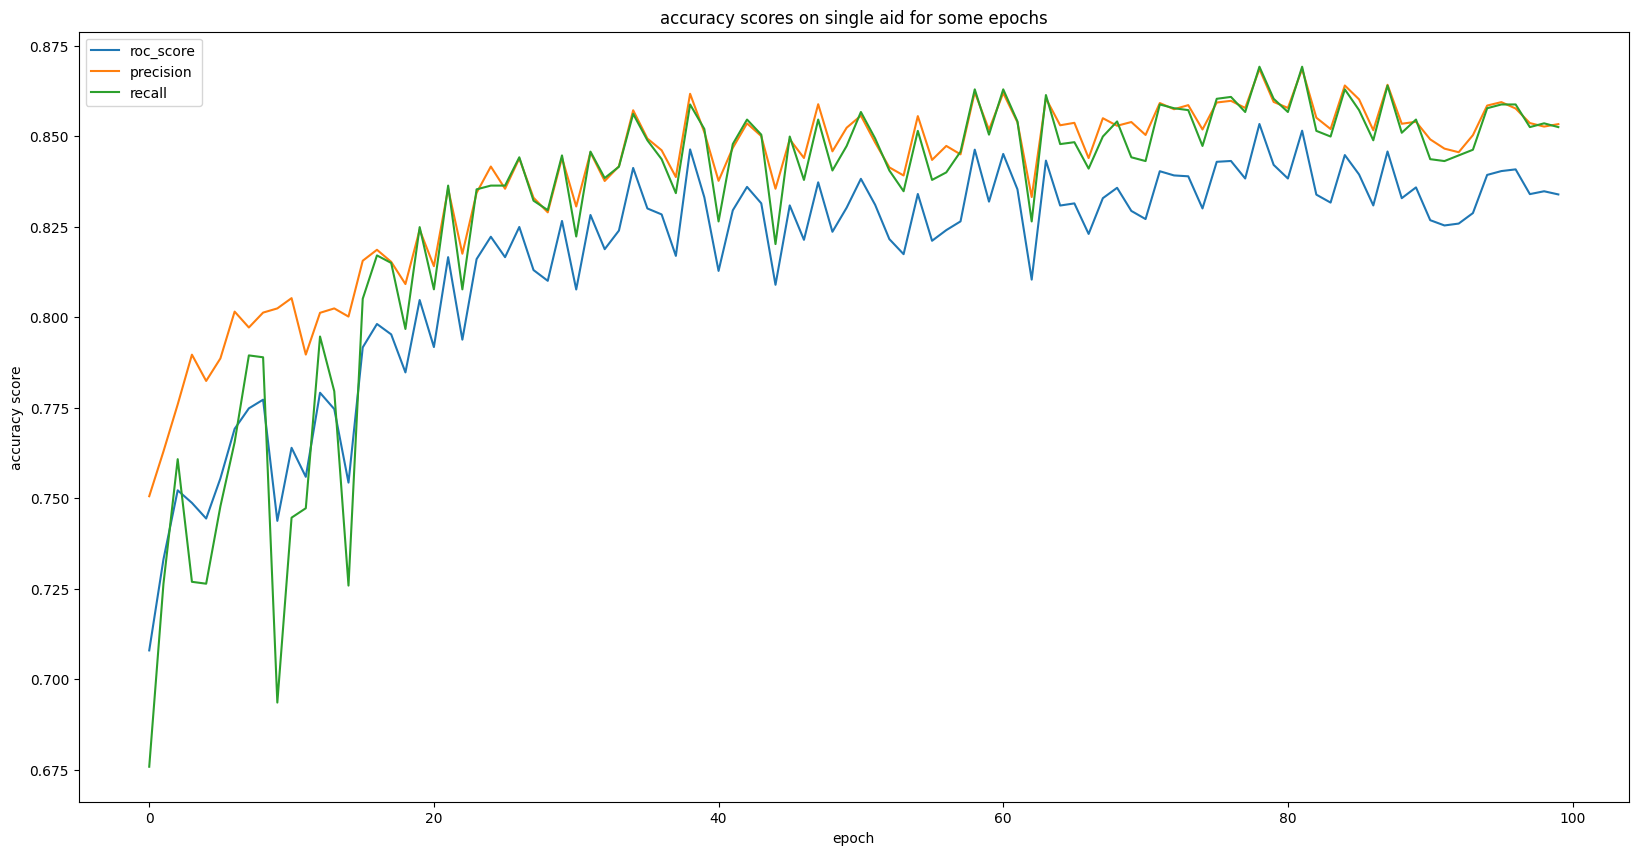

In [42]:
plt.figure(figsize=(20,10))
plt.plot(accuracy_storage.roc_score, label="roc_score")
plt.plot(accuracy_storage.precision, label="precision")
plt.plot(accuracy_storage.recall, label="recall")
plt.xlabel("epoch")
plt.ylabel("accuracy score")
plt.title("accuracy scores on single aid for some epochs")
plt.legend()
plt.show()